
# Data and computations for paper 

Lars G. Johnsen
National Library of Norway

In [1]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
mu.update('collocations')
from collocations import dist_coll_urn, urn_coll, calculate_midpoint, dist
import pandas as pd

Updated file `C:\Users\yoons\Documents\GitHub\newspapers_coll_conc\collocations.py`

In [2]:
def df_jaccard(df, col1, col2, number=100, asc=False):
    s1 = df.sort_values(by=col1, ascending=asc)[:number].index
    s2 = df.sort_values(by=col2, ascending=asc)[:number].index
    
    #print(len(set(s1)&set(s2)))
    
    return jaccard(s1, s2)

In [4]:
def jaccards(s1, s2):
    return len(set(s1)&set(s2)),len(set(s1)|set(s2))

In [5]:
def jaccard(s1, s2):
    return len(set(s1)&set(s2))/len(set(s1)|set(s2))

In [6]:
def large_corpus_dist_coll(collword, urns = None, after= 10, before = 0, n = 300):
    colls_freq = []
    colls_dist = []
    coll = pd.DataFrame()
    for i in range(0, len(urns), n):
        a = urn_coll(collword, urns = urns[i:i + n], after= after, before = before)
        colls_freq.append(nb.frame(a['freq']))
        colls_dist.append(nb.frame(a['dist']))
    coll['freq'] = pd.concat(colls_freq, axis=1, sort=False).sum(axis=1)
    coll['dist'] = pd.concat(colls_dist, axis = 1, sort=False).mean(axis=1)
    coll['dist_score'] = round(dist(coll['dist'], calculate_midpoint(before, after), coll['freq']), 2)
    return coll

In [7]:
def large_corpus_coll(collword, urns = None, after= 5, before = 5, n = 300):
    colls = []
    for i in range(0, len(urns), n):
        colls.append(nb.urn_coll(collword, urns=urns[i:i + n], after= after, before = before))
    coll = pd.concat(colls, axis=1, sort=False).sum(axis=1)
    return pd.DataFrame(coll)

In [8]:
def make_coll_df(small, large, tot):
    """take two collocations, small and large, and a reference tot. The reference must av a column call tot as well"""
    coll = pd.DataFrame()
    coll['small'] = small['freq']
    coll['large'] = large['freq']
    #coll['ratio'] = coll['small']/coll['large']
    coll['srel'] = coll.small/coll.small.sum()
    coll['lrel'] = coll.large/coll.large.sum()
    coll['ratio'] = coll.srel/coll.lrel
    coll['adjusted'] = coll.small**0.01*coll.ratio
    coll['nb'] = coll.small/tot.tot
    return coll

In [44]:
def make_dcoll_df(dists, norm, tot):
    coll = pd.DataFrame()
    coll['score'] = norm/dists[2]
    coll['nb'] = dists.freq/(dists.freq.sum()*tot.tot)
    return coll

### Reference corpus

The reference is the total counts from approximately 450 000 books from nb.no

In [9]:
tot = nb.frame(nb.totals(50000), 'tot')

In [10]:
nb.normalize_corpus_dataframe(tot)
tot.head()

tot
.    0.058921
,    0.051453
og   0.025297
i    0.021425
det  0.012728

# Corpus

The corpus for doing collocations is a sample of 800 books from fictional literature, dewey decimal code 813.

In [11]:
smd = 5
lmd = 10
collword = 'spise'

In [12]:
corpus = nb.book_corpus(words=[collword], ddk="813%", period=(1980, 2000), limit = 5000)

In [13]:
print(len(corpus))
corpus.head()

4840


urn           author               title  year
0  2008022600036       Baer, Judy     Lexi møter AIDS  1995
1  2014012108066  Summers, Ashley  Vinternattens gave  2000
2  2008021100091   Gifford, Barry   Lula &amp; Sailor  1994
3  2007103100036   Sandford, John        Offerets lov  1992
4  2008022704088    King, Stephen         Rose Madder  1995

Set up the distance parameters and collword, smd is small distance while lmd is large distance. These values are half of the actual window, and used to make a normalized score, call ascore. See below.

In [14]:
a1 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after= int(2*smd), before = 0), 'freq')
a2 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after= int(2*lmd), before = 0), 'freq')

In [15]:
b1 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after=0, before = int(2*smd)), 'freq')
b2 = nb.frame(large_corpus_dist_coll(collword, urns=list(corpus.urn), after=0, before = int(2*lmd)), 'freq')

# Store the data subsequent use

In [47]:
a1.to_csv('spise_large_after.csv')
a2.to_csv('spise_small_after.csv')
b1.to_csv('spise_large_before.csv')
b2.to_csv('spise_small_before.csv')


## Create collocation dataframe 

Based on data from a1 and a2, and b1 and b2. The name for the collocations after is `coll` while `collb` is for the collocates coming before.

In [16]:
coll = make_coll_df(a1, a2, tot)
collb = make_coll_df(b1, b2, tot)

In [45]:
dists = make_dcoll_df(a1, smd, tot)

## Sorting 

Sorting on the reference is by column 'nb'

In [17]:
coll[coll.small > 1].sort_values(by='nb', ascending=False)[:20][:20].fillna(0).style.background_gradient()

In [18]:
coll[coll.small < coll.large].sort_values(by='adjusted', ascending=False)[:20].fillna(0).style.background_gradient()

In [19]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20].fillna(0).style.background_gradient()

In [20]:
coll.loc[[',','.', 'og','eller', 'i', 'på']]

small    large      srel      lrel     ratio  adjusted             nb
,      27825.0  52105.0  0.047927  0.045978  1.042399  1.154725  540781.268395
.      44436.0  82809.0  0.076539  0.073071  1.047456  1.165771  754161.271296
og     16528.0  31836.0  0.028469  0.028092  1.013398  1.116767  653345.687601
eller   1999.0   2990.0  0.003443  0.002638  1.305029  1.408083  728110.755572
i       9229.0  18130.0  0.015896  0.015998  0.993654  1.088646  430757.201883
på      8990.0  18032.0  0.015485  0.015911  0.973182  1.065938  937520.459052

# collb

In [21]:
collb[collb.small < collb.large].sort_values(by='adjusted', ascending=False)[:40].fillna(0).style.background_gradient()

In [34]:
collb[collb.small < collb.large].sort_values(by='adjusted', ascending=False).loc[['.','og',',']].fillna(0).style.background_gradient()

In [22]:
collb.sort_values(by='nb', ascending=False)[:40].fillna(0).style.background_gradient()

In [23]:
collb.sort_values(by='nb', ascending=False).loc[['sterk', 'kruttsterk']].fillna(0).style.background_gradient()

# coll

In [24]:
coll[coll.small == coll.large].sort_values(by='ratio', ascending=False)[:30].fillna(0).style.background_gradient()

In [25]:
coll.sort_values(by='nb', ascending=False)[:30].fillna(0).style.background_gradient()

# jaccard similarity

compare over a range

In [26]:
rng = range(2,40,2)

# for collb

In [27]:
jaccard_scoresb = nb.frame({'ratio': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

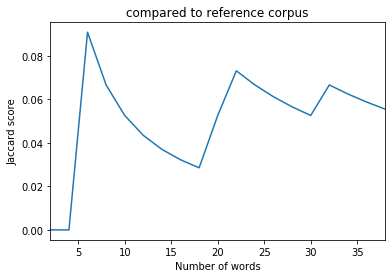

In [28]:
ax = jaccard_scoresb['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

# for coll

In [29]:
jaccard_scores = nb.frame({'ratio': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

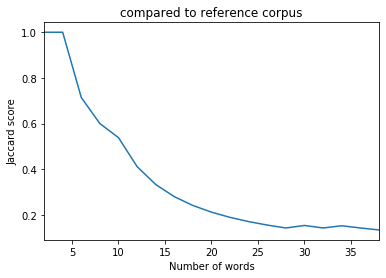

In [30]:
ax = jaccard_scores['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

In [31]:
jaccards(collb[collb.small < collb.large].sort_values(by='ratio', ascending = False)[:60].index, collb.sort_values(by='nb', ascending=False)[:100].index)

(8, 152)